In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

In [2]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.4')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [6]:
pyro.__version__

'1.8.4+9ed468d'

In [7]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

In [8]:
df

,cont_africa,rugged,rgdppc_2000
0,0,0.462,NaN
1,0,2.518,NaN
2,1,0.858,1794.729
3,0,0.013,NaN
4,0,3.427,3703.113
...,...,...,...
229,0,1.677,4860.269
230,0,2.323,787.749
231,1,1.761,9419.122
232,1,0.533,774.010


In [9]:
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

C:\Users\bbece\AppData\Local\Temp\ipykernel_32348\3494630367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rgdppc_2000"] = np.log(df["rgdppc_2000"])


In [10]:
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

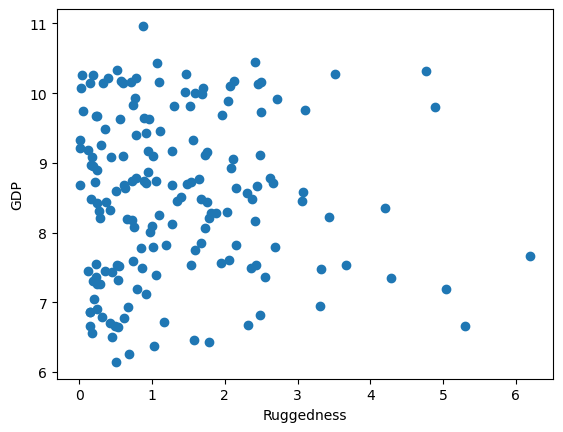

In [11]:
import matplotlib.pyplot as plt
plt.scatter(ruggedness, log_gdp)
plt.xlabel("Ruggedness")
plt.ylabel("GDP")
plt.show()

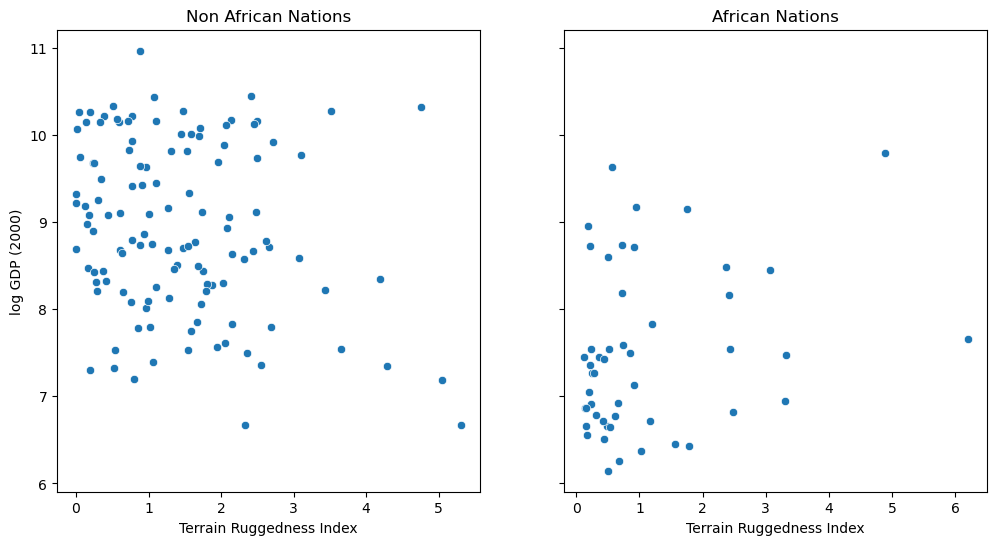

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [21]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    intercept=pyro.param("a", lambda: torch.randn(()))
    beta_cont = pyro.param("bA", lambda: torch.randn(()))
    beta_rugg = pyro.param("bR", lambda: torch.randn(()))
    beta_cont_rugg = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    mean = intercept + beta_cont * is_cont_africa + beta_rugg * ruggedness + beta_cont_rugg * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True, render_params=True)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [29]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def model(is_cont_africa, ruggedness, log_gdp=None):
    intercept=pyro.sample("a", dist.Normal(0., 10.))
    beta_cont = pyro.sample("bA", dist.Normal(0., 1.))
    beta_rugg = pyro.sample("bR", dist.Normal(0., 1.))
    beta_cont_rugg = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = intercept + beta_cont * is_cont_africa + beta_rugg * ruggedness + beta_cont_rugg * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

In [31]:
def custom_guide(is_cont_africa, ruggedness, log_gdp=None):
    a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
    a_scale = pyro.param('a_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', lambda: torch.randn(3))
    weights_scale = pyro.param('weights_scale', lambda: torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}

In [33]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)

In [34]:
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

Elbo loss: 700.0693442225456
Elbo loss: 543.3019431829453
Elbo loss: 465.36677849292755
Elbo loss: 409.27321046590805
Elbo loss: 329.66896617412567
Elbo loss: 252.3683232665062
Elbo loss: 249.48920553922653
Elbo loss: 253.35215479135513
Elbo loss: 252.6051323413849
Elbo loss: 247.06005036830902


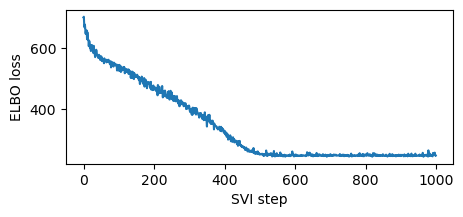

In [35]:

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [37]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

a 0.66135216
bA 0.2669241
bR 0.06167726
bAR 0.6213173
sigma 1.0
AutoNormal.locs.a 9.178402
AutoNormal.scales.a 0.07029709
AutoNormal.locs.bA -1.8277878
AutoNormal.scales.bA 0.1333429
AutoNormal.locs.bR -0.20171224
AutoNormal.scales.bR 0.03893584
AutoNormal.locs.bAR 0.34465936
AutoNormal.scales.bAR 0.085991144
AutoNormal.locs.sigma -2.2365952
AutoNormal.scales.sigma 0.06379764


In [38]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

gamma_within_africa = samples["bR"] + samples["bAR"]
gamma_outside_africa = samples["bR"]

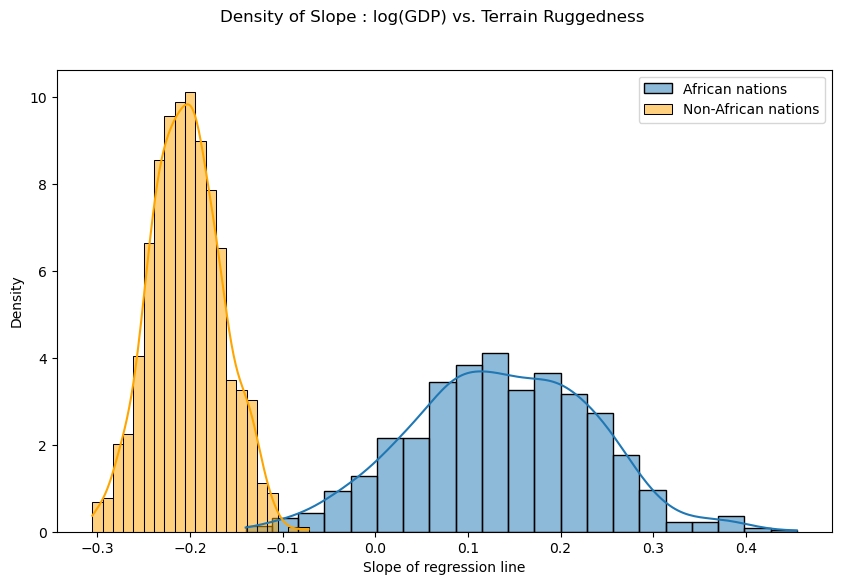

In [39]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

In [40]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(is_cont_africa, ruggedness, log_gdp=None)
svi_gdp = svi_samples["obs"]

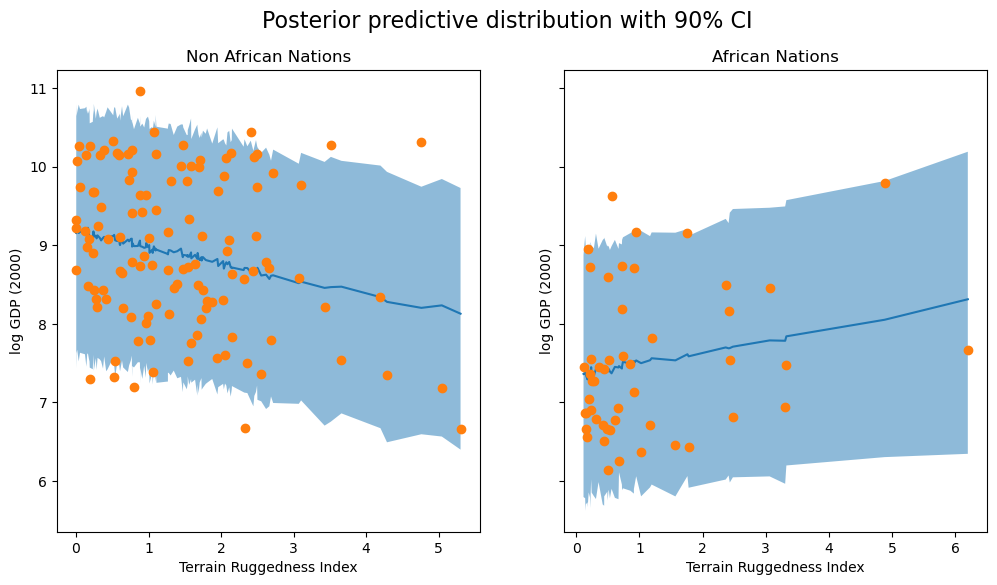

In [41]:
predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
african_nations = predictions[predictions["cont_africa"] == 1].sort_values(by=["rugged"])
non_african_nations = predictions[predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["y_perc_5"], african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations");

In [42]:
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

Elbo loss: 488.4388330578804
Elbo loss: 342.2395601272583
Elbo loss: 266.7413058876991
Elbo loss: 251.02651876211166
Elbo loss: 247.21158015727997
Elbo loss: 249.31339991092682
Elbo loss: 248.7462193965912
Elbo loss: 248.61500298976898
Elbo loss: 248.46069186925888
Elbo loss: 247.8192487359047


CPU times: total: 1min 15s
Wall time: 13.6 s


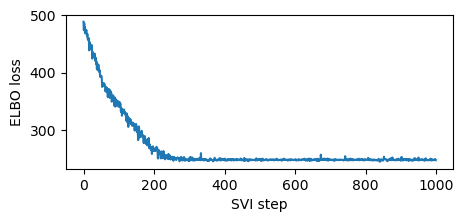

In [43]:
%%time
pyro.clear_param_store()
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
svi = pyro.infer.SVI(model,
                     mvn_guide,
                     pyro.optim.Adam({"lr": 0.02}),
                     pyro.infer.Trace_ELBO())
losses = []
for step in range(1000 if not smoke_test else 2):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

with pyro.plate("samples", 800, dim=-1):
    mvn_samples = mvn_guide(is_cont_africa, ruggedness)

mvn_gamma_within_africa = mvn_samples["bR"] + mvn_samples["bAR"]
mvn_gamma_outside_africa = mvn_samples["bR"]

# Interface note: reuse guide samples for prediction by passing them to Predictive
# via the posterior_samples keyword argument instead of passing the guide as above
assert "obs" not in mvn_samples
mvn_predictive = pyro.infer.Predictive(model, posterior_samples=mvn_samples)
mvn_predictive_samples = mvn_predictive(is_cont_africa, ruggedness, log_gdp=None)

mvn_gdp = mvn_predictive_samples["obs"]

C:\Users\bbece\AppData\Local\Temp\ipykernel_32348\3705028035.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], shade=True, bw_adjust=4)
C:\Users\bbece\AppData\Local\Temp\ipykernel_32348\3705028035.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], shade=True, bw_adjust=4)


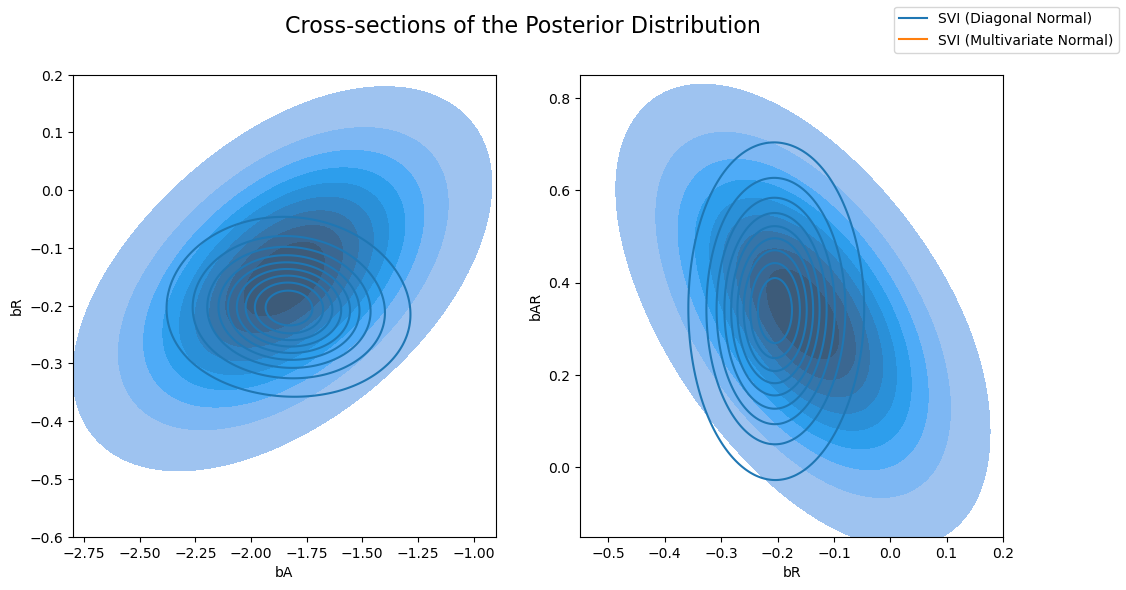

In [44]:
svi_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
svi_mvn_samples = {k: v.detach().cpu().numpy() for k, v in mvn_samples.items()}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], shade=True, bw_adjust=4)
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.8, -0.9), ylim=(-0.6, 0.2))

sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1],bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], shade=True, bw_adjust=4)
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.55, 0.2), ylim=(-0.15, 0.85))


for label, color in zip(["SVI (Diagonal Normal)", "SVI (Multivariate Normal)"], sns.color_palette()[:2]):
    plt.plot([], [],
                label=label, color=color)

fig.legend(loc='upper right')

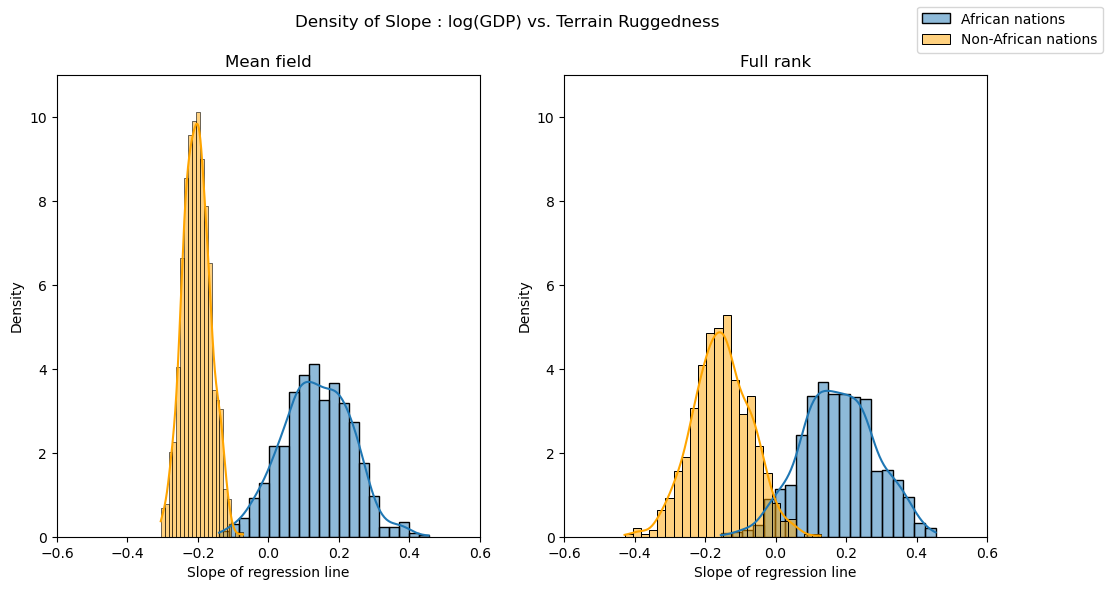

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

sns.histplot(gamma_within_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", color="orange", label="Non-African nations")
axs[0].set(title="Mean field", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

sns.histplot(mvn_gamma_within_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", label="African nations")
sns.histplot(mvn_gamma_outside_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", color="orange", label="Non-African nations")
axs[1].set(title="Full rank", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

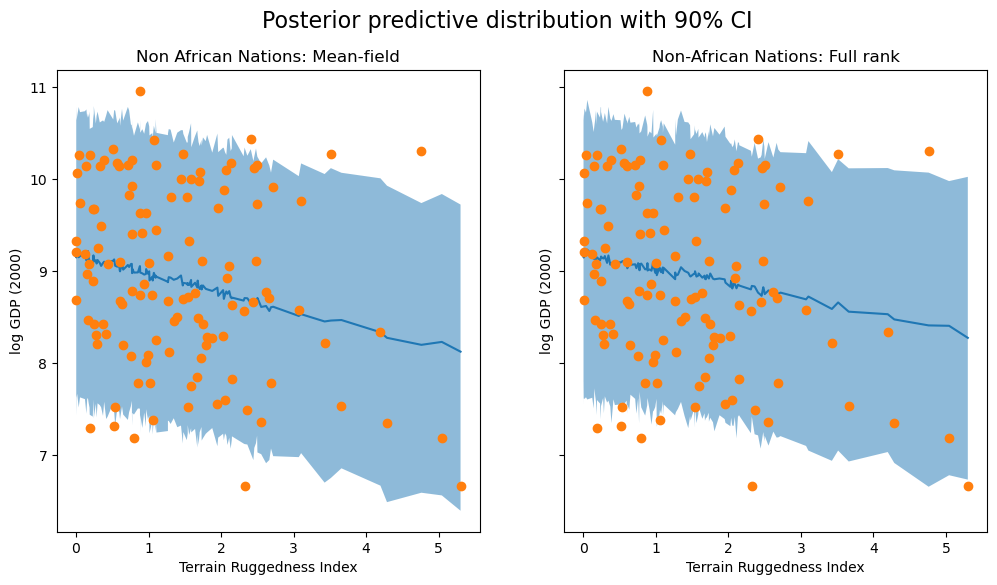

In [46]:
mvn_predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": mvn_gdp.mean(dim=0).detach().cpu().numpy(),
    "y_perc_5": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
mvn_non_african_nations = mvn_predictions[mvn_predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations: Mean-field")

ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_mean"])
ax[1].fill_between(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_perc_5"], mvn_non_african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non-African Nations: Full rank");

### Coin flip example

In [59]:
data = torch.tensor([1., 0., 0., 1., 0., 1., 1., 1., 1., 1.])

In [47]:
import pyro.distributions as dist

def model(data):
    # define the hyperparameters that control the Beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the Beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    for i in range(len(data)):
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

In [57]:
def guide(data):
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0), constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0), constraint=constraints.positive)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

In [61]:
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = pyro.optim.Adam(adam_params)
# setup the inference algorithm
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO())

n_steps = 5000
# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

..................................................

In [62]:
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

In [63]:
alpha_q

16.88214874267578

In [65]:
beta_q

12.960405349731445

In [68]:
import math
# here we use some facts about the Beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nBased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


Based on the data and our prior belief, the fairness of the coin is 0.566 +- 0.089


### Attempt Beta Model


In [90]:
%matplotlib inline

import torch
import pyro
import numpy as np
import matplotlib.pyplot as plt
# set the pyro seed for reproducibility
pyro.set_rng_seed(0)

# sample 100 samples from a beta distribution with parameters alpha and beta
samples_1a = pyro.sample("beta_samples1a", pyro.distributions.Beta(2.5, 4), sample_shape=(5000,))
samples_1b = pyro.sample("beta_samples1b", pyro.distributions.Beta(500+1, 800+1), sample_shape=(5000,))
samples_2 = pyro.sample("beta_samples2", pyro.distributions.Beta(2000+1, 8000+1), sample_shape=(5000,))

baseline = 0.5
get_samples_3 = lambda samples_1: np.asarray([samples_1[i]*(baseline/samples_2[i]) if samples_1[i] <= samples_2[i] else 1- ((1-baseline)/(1-samples_2[i]))*(1-samples_1[i]) for i, _ in enumerate(list(samples_1))])
samples_3a = get_samples_3(samples_1a)
samples_3b = get_samples_3(samples_1b)

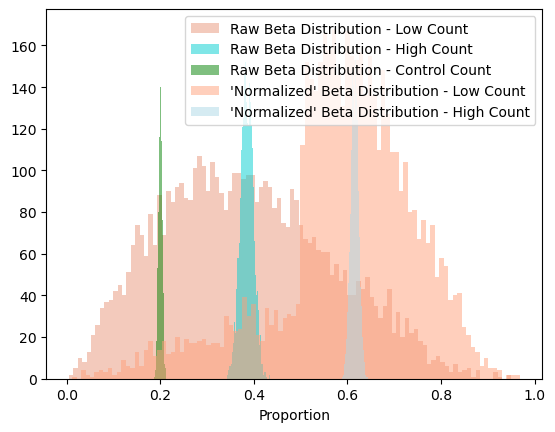

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


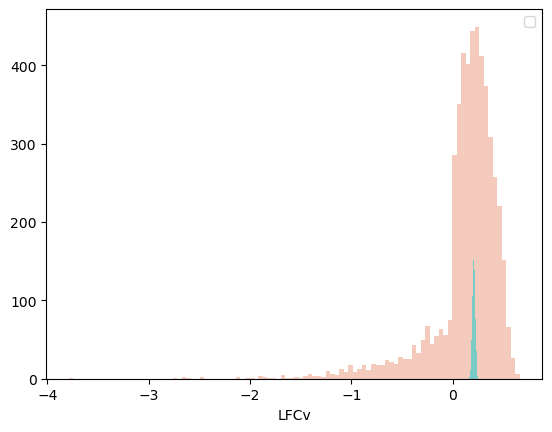

In [91]:
plt.hist(samples_1a, bins=100, alpha=0.5, color="darksalmon", label="Raw Beta Distribution - Low Count")
plt.hist(samples_1b, bins=100, alpha=0.5, color="darkturquoise", label="Raw Beta Distribution - High Count")
plt.hist(samples_2, bins=100,alpha=0.5, color="green", label="Raw Beta Distribution - Control Count")
plt.hist(samples_3a, bins=100,alpha=0.5, color="lightsalmon", label="'Normalized' Beta Distribution - Low Count")
plt.hist(samples_3b, bins=100,alpha=0.5, color="lightblue", label="'Normalized' Beta Distribution - High Count")
plt.xlabel("Proportion")
plt.legend()
plt.show()
plt.hist(np.log(samples_3a/baseline), bins=100,alpha=0.5, color="darksalmon")
plt.hist(np.log(samples_3b/baseline), bins=100,alpha=0.5, color="darkturquoise")
plt.xlabel("LFCv")
plt.legend()
plt.show()

In [190]:
samples_3a/0.5

array([1.2912092 , 0.93669146, 0.9272302 , ..., 0.82637537, 1.0832112 ,
       0.81727743], dtype=float32)

In [95]:
print(np.mean(np.log(samples_3a/baseline)))
print(np.mean(np.log(samples_3b/baseline)))

mean_hat_3a = np.mean(np.log(samples_3a/baseline))
mean_hat_3b = np.mean(np.log(samples_3b/baseline))

var_hat_3a = np.var(np.log(samples_3a/baseline))
var_hat_3b = np.var(np.log(samples_3b/baseline))


get_james_stein_estimate = lambda n, var, mu, k : (1 - k * (var / (n-1 + var))) * mu
get_bayesian_estimate = lambda n, var_hat, mu, var_0:  ((var_0 * mu) + (var_hat * 0)) / (var_0 + (n * var_hat))

get_bayesian_estimate_known =  lambda mean_hat, var_hat, var_0 : (mean_hat * var_hat) / (var_0 + var_hat)

get_simple_shrink = lambda mean_hat, var_hat, alpha:  mean_hat * (1 - alpha)
print("Low count")
#print(get_james_stein_estimate(2,var_hat_3a, mean_hat_3a, 1))
print(get_bayesian_estimate(1,var_hat_3a, mean_hat_3a, 0.1)) # 

print("High count")
#print(get_james_stein_estimate(2,var_hat_3b, mean_hat_3b, 1))
print(get_bayesian_estimate(1,var_hat_3b, mean_hat_3b, 0.1))
#print(get_james_stein_estimate(100,var_hat_3b, mean_hat_3b, 1))

0.1240616
0.20763035
Low count
0.055486488737659
High count
0.2072236171599287


1/31/2023: So the solution I have which may not be the best but still has the same effect is to use the Normal-Normal model (or normal-inverse-gamma) but set n to be 1 since we only have 1 observed data point (could try with 3 for all three replicates).

Next, I can try a Beta-Binomial model to get the Beta posterior, then transform the posterior (via normalization and logFC) to get the distribution. I can have 3 posteriors for each replicate and take the mean of the posteriors from the replicates. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


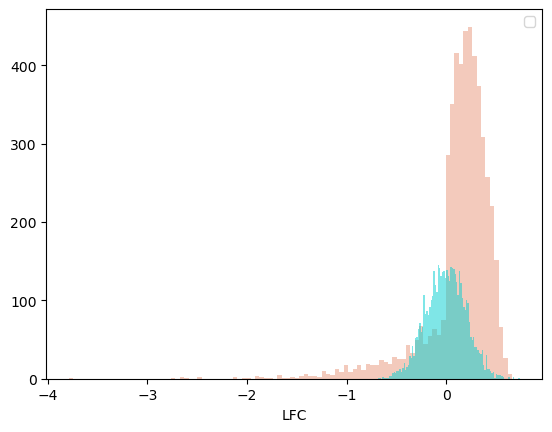

In [96]:
plt.hist(np.log(samples_3a/baseline), bins=100,alpha=0.5, color="darksalmon")
plt.hist(pyro.sample("prior", pyro.distributions.Normal(0, 0.2), sample_shape=(len(samples_3a),)), bins=100,alpha=0.5, color="darkturquoise")
plt.xlabel("LFC")
plt.legend()
plt.show()

In [ ]:

james_stein_mean_hat_3a = 1-((mean_hat_3a/len(samples_3a))*(var_hat_3a/(len(samples_3a)-1 + var_hat_3a)))
print(james_stein_mean_hat_3a)

prior_var = 1
prior_mean = 0
get_bayesian_mean = lambda mean_hat_3, var_hat_3 : ((prior_var * prior_mean) + (var_hat_3 * mean_hat_3)) / (prior_var + var_hat_3) 

bayesian_mean_hat_3a = get_bayesian_mean(mean_hat_3a, var_hat_3a)
bayesian_mean_hat_3b = get_bayesian_mean(mean_hat_3b, var_hat_3b)
print(bayesian_mean_hat_3a)
print(bayesian_mean_hat_3b)

In [ ]:
# Top solutions are not working from ChatGPT - get posterior distribution from https://stats.stackexchange.com/questions/46937/bayesian-analysis-normal-distribution-with-unknown-mean-and-variance

# However, above assumes that data stems from normal distribution. Perhaps we could use Pyro on the emprical distribution itself?

Try Beta Binomial Solution

In [1]:
pop1_count_rep1 = 3
pop2_count_rep1 = 6
pop1_count_rep2 = 70
pop2_count_rep2 = 50
pop1_count_rep3 = 15
pop2_count_rep3 = 21

ctrl1_pop1_count_rep1 = 50
ctrl1_pop2_count_rep1 = 150

ctrl1_pop1_count_rep2 = 62
ctrl1_pop2_count_rep2 = 142

ctrl1_pop1_count_rep3 = 79
ctrl1_pop2_count_rep3 = 141

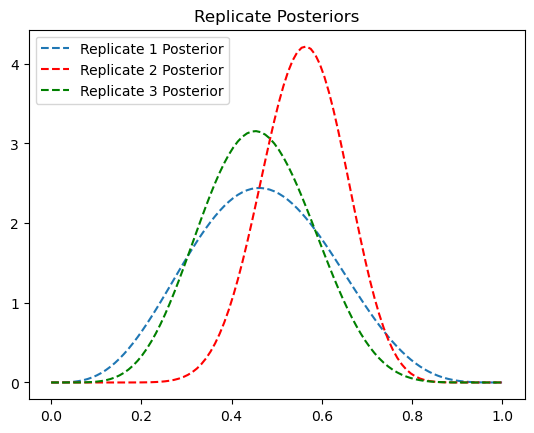

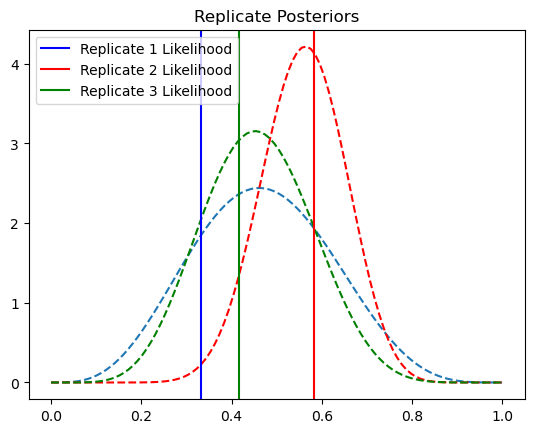

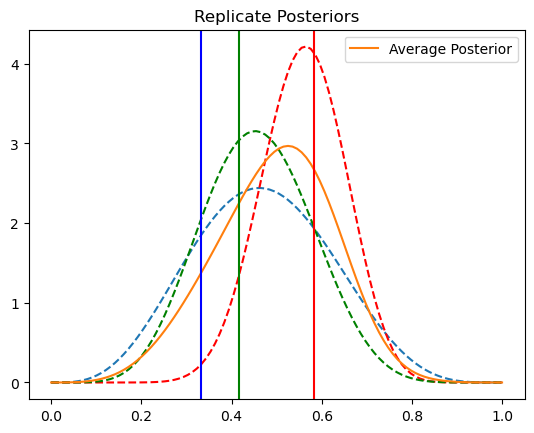

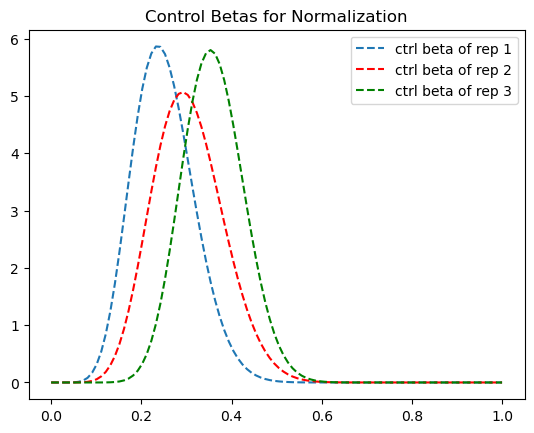

In [80]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

# Strength of the prior - perhaps try an Emperical Bayes approach for setting the prior?
alpha_0 = 4
beta_0 = 4

divisible_factor_pop1_rep1 = 5
divisible_factor_pop2_rep1 = 5
divisible_factor_pop1_rep2 = 6
divisible_factor_pop2_rep2 = 6
divisible_factor_pop1_rep3 = 4.5
divisible_factor_pop2_rep3 = 4.5

alpha_rep1 = pop1_count_rep1 / divisible_factor_pop1_rep1
beta_rep1 = pop2_count_rep1 / divisible_factor_pop2_rep1

alpha_ctrl_rep1 = ctrl1_pop1_count_rep1 / divisible_factor_pop1_rep1
beta_ctrl_rep1 = ctrl1_pop2_count_rep1 / divisible_factor_pop2_rep1


alpha_rep2 = pop1_count_rep2 / divisible_factor_pop1_rep2
beta_rep2 = pop2_count_rep2 / divisible_factor_pop2_rep2

alpha_ctrl_rep2 = ctrl1_pop1_count_rep2 / divisible_factor_pop1_rep2
beta_ctrl_rep2 = ctrl1_pop2_count_rep2 / divisible_factor_pop2_rep2

alpha_rep3 = pop1_count_rep3 / divisible_factor_pop1_rep3
beta_rep3 = pop2_count_rep3 / divisible_factor_pop2_rep3

alpha_ctrl_rep3 = ctrl1_pop1_count_rep3 / divisible_factor_pop1_rep3
beta_ctrl_rep3 = ctrl1_pop2_count_rep3 / divisible_factor_pop2_rep3

x = np.linspace(0, 1.0, 100)
beta_post_rep1_pdf = beta.pdf(x, alpha_rep1 + alpha_0, beta_rep1 + beta_0)
beta_ctrl1_rep1_pdf = beta.pdf(x, alpha_ctrl_rep1, beta_ctrl_rep1)

beta_post_rep2_pdf = beta.pdf(x, alpha_rep2 + alpha_0, beta_rep2 + beta_0)
beta_ctrl1_rep2_pdf = beta.pdf(x, alpha_ctrl_rep2, beta_ctrl_rep2)

beta_post_rep3_pdf = beta.pdf(x, alpha_rep3 + alpha_0, beta_rep3 + beta_0)
beta_ctrl1_rep3_pdf = beta.pdf(x, alpha_ctrl_rep3, beta_ctrl_rep3)

beta_post_avg_pdf = (beta_post_rep1_pdf + beta_post_rep2_pdf + beta_post_rep3_pdf) / 3

plt.plot(x, beta_post_rep1_pdf, "--", label="Replicate 1 Posterior")
plt.plot(x, beta_post_rep2_pdf, "r--", label="Replicate 2 Posterior")
plt.plot(x, beta_post_rep3_pdf, "g--", label="Replicate 3 Posterior")
plt.title("Replicate Posteriors")
plt.legend()
plt.show()

plt.plot(x, beta_post_rep1_pdf, "--")
plt.plot(x, beta_post_rep2_pdf, "r--")
plt.plot(x, beta_post_rep3_pdf, "g--")
plt.axvline(x=alpha_rep1/(alpha_rep1+beta_rep1), color="blue", label="Replicate 1 Likelihood")
plt.axvline(x=alpha_rep2/(alpha_rep2+beta_rep2), color="red", label="Replicate 2 Likelihood")
plt.axvline(x=alpha_rep3/(alpha_rep3+beta_rep3), color="green", label="Replicate 3 Likelihood")
plt.title("Replicate Posteriors")
plt.legend()
plt.show()


plt.plot(x, beta_post_rep1_pdf, "--")
plt.plot(x, beta_post_rep2_pdf, "r--")
plt.plot(x, beta_post_rep3_pdf, "g--")
plt.plot(x, beta_post_avg_pdf, "-", label="Average Posterior")
plt.axvline(x=alpha_rep1/(alpha_rep1+beta_rep1), color="blue")
plt.axvline(x=alpha_rep2/(alpha_rep2+beta_rep2), color="red")
plt.axvline(x=alpha_rep3/(alpha_rep3+beta_rep3), color="green")
plt.title("Replicate Posteriors")
plt.legend()
plt.show()

plt.plot(x, beta_ctrl1_rep1_pdf, "--", label="ctrl beta of rep 1")
plt.plot(x, beta_ctrl1_rep2_pdf, "r--", label="ctrl beta of rep 2")
plt.plot(x, beta_ctrl1_rep3_pdf, "g--", label="ctrl beta of rep 3")
plt.title("Control Betas for Normalization")
plt.legend()
plt.show()

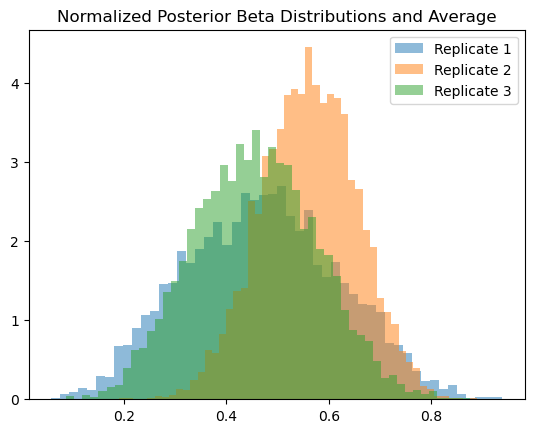

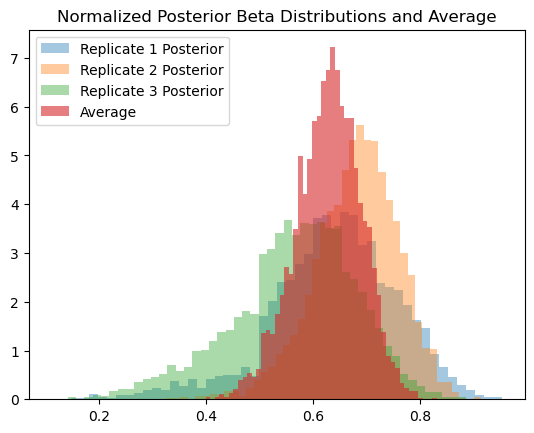

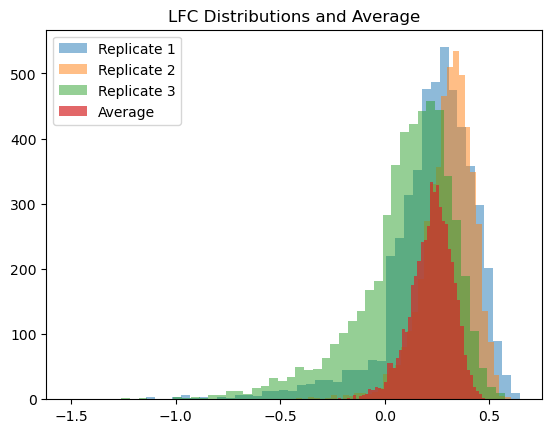

In [83]:

monte_carlo_trials = 5000

beta_post_rep1_mc_samples = beta.rvs(alpha_rep1 + alpha_0, beta_rep1 + beta_0, size=monte_carlo_trials)
beta_ctrl1_rep1_mc_samples = beta.rvs(alpha_ctrl_rep1, beta_ctrl_rep1, size=monte_carlo_trials)

beta_post_rep2_mc_samples = beta.rvs(alpha_rep2 + alpha_0, beta_rep2 + beta_0, size=monte_carlo_trials)
beta_ctrl1_rep2_mc_samples = beta.rvs(alpha_ctrl_rep2, beta_ctrl_rep2, size=monte_carlo_trials)


beta_post_rep3_mc_samples = beta.rvs(alpha_rep3 + alpha_0, beta_rep3 + beta_0, size=monte_carlo_trials)
beta_ctrl1_rep3_mc_samples = beta.rvs(alpha_ctrl_rep3, beta_ctrl_rep3, size=monte_carlo_trials)

plt.hist(beta_post_rep1_mc_samples, bins=50, alpha=0.5, label="Replicate 1", density=True)
plt.hist(beta_post_rep2_mc_samples, bins=50, alpha=0.5, label="Replicate 2", density=True)
plt.hist(beta_post_rep3_mc_samples, bins=50, alpha=0.5, label="Replicate 3", density=True)
plt.legend()
plt.title("Normalized Posterior Beta Distributions and Average")
plt.show()

normalize_beta_distribution = lambda posterior_beta_samples, control_beta_samples, baseline: np.asarray([posterior_beta_samples[i]*(baseline/control_beta_samples[i]) if posterior_beta_samples[i] <= control_beta_samples[i] else 1- ((1-baseline)/(1-control_beta_samples[i]))*(1-posterior_beta_samples[i]) for i, _ in enumerate(list(posterior_beta_samples))])

baseline = 0.5
beta_post_rep1_mc_samples_normalized = normalize_beta_distribution(beta_post_rep1_mc_samples,beta_ctrl1_rep1_mc_samples,baseline)
beta_post_rep2_mc_samples_normalized = normalize_beta_distribution(beta_post_rep2_mc_samples,beta_ctrl1_rep2_mc_samples,baseline)
beta_post_rep3_mc_samples_normalized = normalize_beta_distribution(beta_post_rep3_mc_samples,beta_ctrl1_rep3_mc_samples,baseline)
beta_post_avg_mc_samples_normalized = (beta_post_rep1_mc_samples_normalized + beta_post_rep2_mc_samples_normalized + beta_post_rep3_mc_samples_normalized)/3

plt.hist(beta_post_rep1_mc_samples_normalized, bins=50, alpha=0.4, label="Replicate 1 Posterior", density=True)
plt.hist(beta_post_rep2_mc_samples_normalized, bins=50, alpha=0.4, label="Replicate 2 Posterior", density=True)
plt.hist(beta_post_rep3_mc_samples_normalized, bins=50, alpha=0.4, label="Replicate 3 Posterior", density=True)
plt.hist(beta_post_avg_mc_samples_normalized, bins=50, alpha=0.6, label="Average", density=True)
plt.legend()
plt.title("Normalized Posterior Beta Distributions and Average")
plt.show()

plt.hist(np.log(beta_post_rep1_mc_samples_normalized/baseline), bins=50, alpha=0.5, label="Replicate 1")
plt.hist(np.log(beta_post_rep2_mc_samples_normalized/baseline), bins=50, alpha=0.5, label="Replicate 2")
plt.hist(np.log(beta_post_rep3_mc_samples_normalized/baseline), bins=50, alpha=0.5, label="Replicate 3")
plt.hist(np.log(beta_post_avg_mc_samples_normalized/baseline), bins=50, alpha=0.7, label="Average")
plt.title("LFC Distributions and Average")
plt.legend()
plt.show()

In [218]:
beta.rvs(np.asarray([1,2,3]), np.asarray([1,2,3]), size=10)

ValueError: size does not match the broadcast shape of the parameters. 10, (10,), (3,)

In [20]:
# Make into function
from typing import List
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

seed=233423

def shrink_LFC_from_counts(pop1_guide_counts_list: List[int], pop2_guide_counts_list: List[int], pop1_dup_factor_list: List[int], pop2_dup_factor_list: List[int], pop1_ctrl_counts_list: List[List[int]], pop2_ctrl_counts_list: List[List[int]], alpha_prior=4, beta_prior=4, baseline_proportion=0.5, monte_carlo_trials=5000):
    assert len(pop1_guide_counts_list) == len(pop2_guide_counts_list) == len(pop1_dup_factor_list) == len(pop2_dup_factor_list) == len(pop1_ctrl_counts_list) == len(pop1_ctrl_counts_list), "Count list sizes must be same size, corresponding to total replicates"
    assert alpha_prior>0, "alpha prior must be > 0"
    assert beta_prior>0, "beta prior must be > 0"
    assert (baseline_proportion >= 0) and (baseline_proportion <= 1), "baseline proportion must be between 0 and 1 inclusive"

    reps = len(pop1_guide_counts_list)

    guide_alpha_list = [pop1_guide_counts_list[rep_i]/pop1_dup_factor_list[rep_i] for rep_i in range(reps)]
    guide_beta_list = [pop2_guide_counts_list[rep_i]/pop2_dup_factor_list[rep_i] for rep_i in range(reps)]

    ctrl_alpha_list = [sum([pop1_ctrl_counts_list[rep_i][ctrl_i]/pop1_dup_factor_list[rep_i] for ctrl_i in range(len(pop1_ctrl_counts_list[rep_i]))]) for rep_i in range(reps)]
    ctrl_beta_list = [sum([pop2_ctrl_counts_list[rep_i][ctrl_i]/pop2_dup_factor_list[rep_i] for ctrl_i in range(len(pop2_ctrl_counts_list[rep_i]))]) for rep_i in range(reps)]

    # NOTE: Technically dont need to sample from beta for nonshrunk case, since probabilities can be calculated via MLE formula instead of having to use Monte Carlo. But will just use monte carlo to be apples-to-apples with the shrinkage estimator.
    guide_beta_nonshrunk_mc_samples_list = [beta.rvs(guide_alpha_list[rep_i] + 1, guide_beta_list[rep_i] + 1, size=monte_carlo_trials, random_state=seed) for rep_i in range(reps)]
    ctrl_beta_nonshrunk_mc_samples_list = [beta.rvs(ctrl_alpha_list[rep_i] + 1, ctrl_beta_list[rep_i] + 1, size=monte_carlo_trials, random_state=seed) for rep_i in range(reps)]

    guide_beta_posterior_mc_samples_list = [beta.rvs(guide_alpha_list[rep_i] + alpha_prior + 1, guide_beta_list[rep_i] + beta_prior + 1, size=monte_carlo_trials, random_state=seed) for rep_i in range(reps)]
    ctrl_beta_posterior_mc_samples_list = [beta.rvs(ctrl_alpha_list[rep_i] + alpha_prior + 1, ctrl_beta_list[rep_i] + beta_prior + 1, size=monte_carlo_trials, random_state=seed) for rep_i in range(reps)]


    normalize_beta_distribution = lambda posterior_beta_samples, control_beta_samples, baseline: np.asarray([posterior_beta_samples[i]*(baseline/control_beta_samples[i]) if posterior_beta_samples[i] <= control_beta_samples[i] else 1- ((1-baseline)/(1-control_beta_samples[i]))*(1-posterior_beta_samples[i]) for i, _ in enumerate(list(posterior_beta_samples))])

    guide_beta_nonshrunk_mc_samples_normalized_list = [normalize_beta_distribution(guide_beta_nonshrunk_mc_samples_list[rep_i], ctrl_beta_nonshrunk_mc_samples_list[rep_i], baseline_proportion) for rep_i in range(reps)]
    guide_beta_nonshrunk_mc_samples_normalized_averaged = np.sum(guide_beta_nonshrunk_mc_samples_normalized_list, axis=0)/reps
    
    guide_beta_posterior_mc_samples_normalized_list = [normalize_beta_distribution(guide_beta_posterior_mc_samples_list[rep_i], ctrl_beta_posterior_mc_samples_list[rep_i], baseline_proportion) for rep_i in range(reps)]
    guide_beta_posterior_mc_samples_normalized_averaged = np.sum(guide_beta_posterior_mc_samples_normalized_list, axis=0)/reps


    guide_beta_nonshrunk_mc_samples_normalized_lfc_list = [np.log(guide_beta_nonshrunk_mc_samples_normalized_list[rep_i]/baseline_proportion) for rep_i in range(reps)]
    guide_beta_nonshrunk_mc_samples_normalized_lfc_averaged = np.log(guide_beta_nonshrunk_mc_samples_normalized_averaged/baseline_proportion)

    guide_beta_posterior_mc_samples_normalized_lfc_list = [np.log(guide_beta_posterior_mc_samples_normalized_list[rep_i]/baseline_proportion) for rep_i in range(reps)]
    guide_beta_posterior_mc_samples_normalized_lfc_averaged = np.log(guide_beta_posterior_mc_samples_normalized_averaged/baseline_proportion)

    return np.mean(guide_beta_posterior_mc_samples_normalized_lfc_averaged), np.mean(guide_beta_posterior_mc_samples_normalized_averaged), np.mean(guide_beta_nonshrunk_mc_samples_normalized_lfc_averaged), np.mean(guide_beta_nonshrunk_mc_samples_normalized_averaged)

In [32]:
# Temporary, can delete
def KL_beta(alpha_f, beta_f, alpha_g, beta_g):
        return np.log(scipy.special.beta(alpha_g, beta_g)/(scipy.special.beta(alpha_f, beta_f))) + ((alpha_f - alpha_g)*(scipy.special.digamma(alpha_f) - scipy.special.digamma(alpha_f+beta_f))) + ((beta_f - beta_g)*(scipy.special.digamma(beta_f) - scipy.special.digamma(alpha_f+beta_f)))

total = total + KL_beta(np.asarray([1,2,3]), np.asarray([1,2,3]), np.asarray([2,4,6]), np.asarray([2,4,6])) 

In [39]:
test_list = np.asarray([0.1, 0.2, 0.3])

In [42]:
test_list[np.argmin(np.asarray([[9, 11, 14], [34, 1, 11], [12, 21, 12]]), axis=0)]

array([0.1, 0.2, 0.2])

In [82]:
from scipy.stats import binom
from scipy.stats import uniform
from scipy.stats import expon
import numpy as np 
null_proportion = 0.5
target_null_proportion = 0.5
target_positive_population = 0.6

num_ctrl_guides = 50
num_target_null_guides = 500
num_target_positive_guides = 50

reps = 3
max_dup_factor = 20
max_guide_molecule_factor = 200

pop1_dup_factor_list = np.asarray([np.round(uniform.rvs(1, max_dup_factor)) for _ in range(reps)])
pop2_dup_factor_list = np.asarray([np.round(uniform.rvs(1, max_dup_factor)) for _ in range(reps)])

#expon.rvs(loc=1, scale=1000, size=num_guides)
#uniform.rvs(2, 200, size=num_guides)
def get_counts(num_guides, proportion):
    pop1_list_reps = []
    pop2_list_reps = []

    for rep_i in range(reps):
        n_list = np.round(uniform.rvs(2, max_guide_molecule_factor, size=num_guides)).astype(int)
        pop1_list = binom.rvs(n_list, proportion, size=num_guides) 
        pop2_list = n_list - pop1_list

        pop1_list_reps.append(pop1_list * pop1_dup_factor_list[rep_i])
        pop2_list_reps.append(pop2_list * pop2_dup_factor_list[rep_i])
    
    return pop1_list_reps, pop2_list_reps


In [210]:
np.concatenate([[1,2], [3,4], [4,5]])

array([1, 2, 3, 4, 4, 5])

In [83]:
pop1_ctrl_counts_list, pop2_ctrl_counts_list = get_counts(num_ctrl_guides, null_proportion)
pop1_null_guide_counts_list_all, pop2_null_guide_counts_list_all = get_counts(num_target_null_guides, target_null_proportion)
pop1_positive_guide_counts_list_all, pop2_positive_guide_counts_list_all = get_counts(num_target_positive_guides, target_positive_population)

In [84]:
pop1_guide_counts_list_all = [np.concatenate([pop1_null_guide_counts_list_all[rep_i], pop1_positive_guide_counts_list_all[rep_i], pop1_ctrl_counts_list[rep_i]]) for rep_i in range(reps)]
pop2_guide_counts_list_all = [np.concatenate([pop2_null_guide_counts_list_all[rep_i], pop2_positive_guide_counts_list_all[rep_i], pop2_ctrl_counts_list[rep_i]]) for rep_i in range(reps)]

In [85]:
total_deduplicated_counts_per_guide = np.asarray([np.asarray(pop1_guide_counts_list_all[rep_i]) / pop1_dup_factor_list[rep_i] for rep_i in range(reps)]).sum(axis=0) + np.asarray([np.asarray(pop2_guide_counts_list_all[rep_i]) / pop2_dup_factor_list[rep_i] for rep_i in range(reps)]).sum(axis=0)
total_deduplicated_counts_per_ctrl = np.asarray([np.asarray(pop1_ctrl_counts_list[rep_i]) / pop1_dup_factor_list[rep_i] for rep_i in range(reps)]).sum(axis=0) + np.asarray([np.asarray(pop2_ctrl_counts_list[rep_i]) / pop2_dup_factor_list[rep_i] for rep_i in range(reps)]).sum(axis=0)

In [118]:
mean_lfc_shrunk_list = []
mean_prop_shrunk_list = []

mean_lfc_nonshrunk_list = []
mean_prop_nonshrunk_list = []
for guide_i in range(num_target_null_guides+num_target_positive_guides+num_ctrl_guides):
    pop1_guide_counts_list = [pop1_guide_counts_list_all[rep_i][guide_i] for rep_i in range(reps)]
    pop2_guide_counts_list = [pop2_guide_counts_list_all[rep_i][guide_i] for rep_i in range(reps)]
    mean_lfc_shrunk, mean_prop_shrunk, mean_lfc_nonshrunk, mean_prop_nonshrunk = shrink_LFC_from_counts(pop1_guide_counts_list, pop2_guide_counts_list, pop1_dup_factor_list, pop2_dup_factor_list, pop1_ctrl_counts_list, pop2_ctrl_counts_list, alpha_prior=16.9, beta_prior=16.9, baseline_proportion=0.5, monte_carlo_trials=5000)
    mean_lfc_shrunk_list.append(mean_lfc_shrunk)
    mean_prop_shrunk_list.append(mean_prop_shrunk)
    mean_lfc_nonshrunk_list.append(mean_lfc_nonshrunk)
    mean_prop_nonshrunk_list.append(mean_prop_nonshrunk)
    

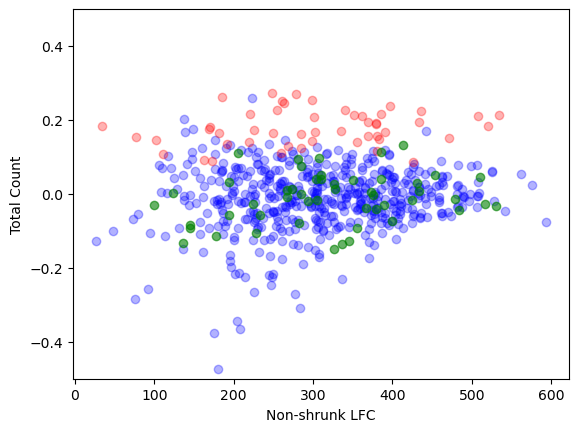

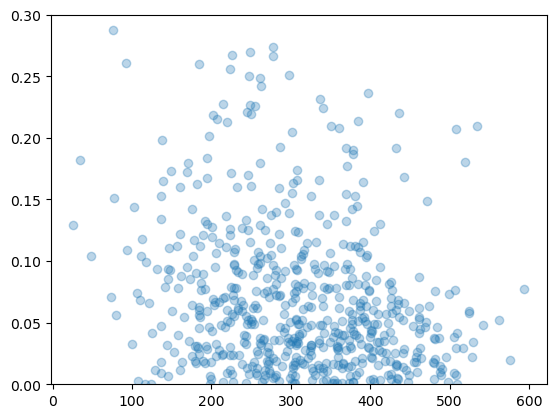

In [121]:
plt.scatter(total_deduplicated_counts_per_guide[:num_target_null_guides], mean_lfc_nonshrunk_list[:num_target_null_guides], alpha=0.3, color="blue")
plt.scatter(total_deduplicated_counts_per_guide[num_target_null_guides:num_target_null_guides+num_target_positive_guides], mean_lfc_nonshrunk_list[num_target_null_guides:num_target_null_guides+num_target_positive_guides], alpha=0.3, color="red")
plt.scatter(total_deduplicated_counts_per_guide[num_target_null_guides+num_target_positive_guides:], mean_lfc_nonshrunk_list[num_target_null_guides+num_target_positive_guides:], alpha=0.6, color="green")
plt.ylabel("Total Count")
plt.xlabel("Non-shrunk LFC")
plt.ylim(-0.5, 0.5)
plt.show()


plt.scatter(total_deduplicated_counts_per_guide, np.abs(mean_lfc_nonshrunk_list - np.mean(mean_lfc_nonshrunk_list)), alpha=0.3)
plt.ylim(0, 0.3)
plt.show()

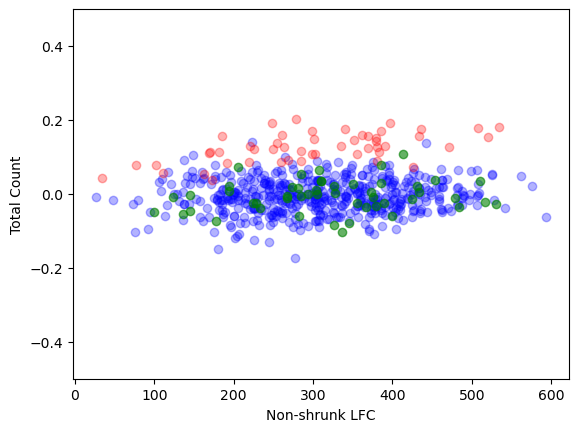

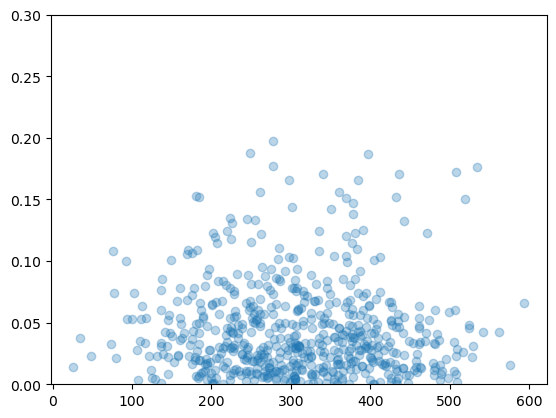

In [122]:
plt.scatter(total_deduplicated_counts_per_guide[:num_target_null_guides], mean_lfc_shrunk_list[:num_target_null_guides], alpha=0.3, color="blue")
plt.scatter(total_deduplicated_counts_per_guide[num_target_null_guides:num_target_null_guides+num_target_positive_guides], mean_lfc_shrunk_list[num_target_null_guides:num_target_null_guides+num_target_positive_guides], alpha=0.3, color="red")
plt.scatter(total_deduplicated_counts_per_guide[num_target_null_guides+num_target_positive_guides:], mean_lfc_shrunk_list[num_target_null_guides+num_target_positive_guides:], alpha=0.6, color="green")
plt.ylabel("Total Count")
plt.xlabel("Non-shrunk LFC")
plt.ylim(-0.5, 0.5)
plt.show()

plt.scatter(total_deduplicated_counts_per_guide, np.abs(mean_lfc_shrunk_list - np.mean(mean_lfc_shrunk_list)), alpha=0.3)
plt.ylim(0, 0.3)
plt.show()

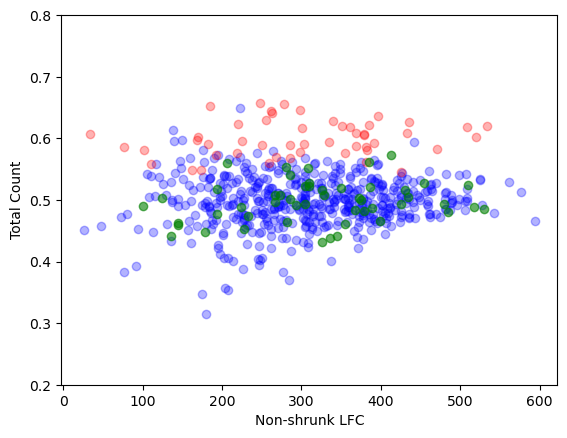

In [96]:
plt.scatter(total_deduplicated_counts_per_guide[:num_target_null_guides], mean_prop_nonshrunk_list[:num_target_null_guides], alpha=0.3, color="blue")
plt.scatter(total_deduplicated_counts_per_guide[num_target_null_guides:num_target_null_guides+num_target_positive_guides], mean_prop_nonshrunk_list[num_target_null_guides:num_target_null_guides+num_target_positive_guides], alpha=0.3, color="red")
plt.scatter(total_deduplicated_counts_per_guide[num_target_null_guides+num_target_positive_guides:], mean_prop_nonshrunk_list[num_target_null_guides+num_target_positive_guides:], alpha=0.6, color="green")
plt.ylabel("Total Count")
plt.xlabel("Non-shrunk LFC")
plt.ylim(0.2, 0.8)
plt.show()

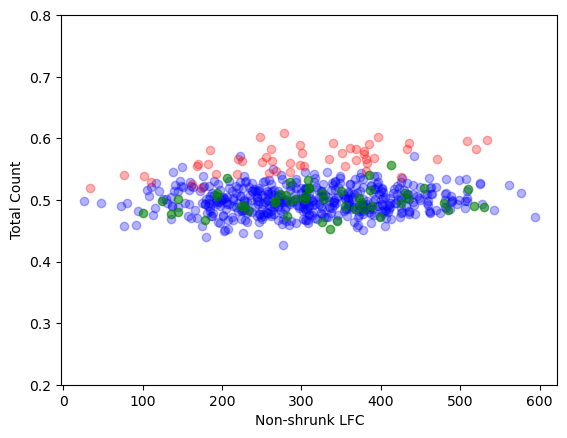

In [98]:
plt.scatter(total_deduplicated_counts_per_guide[:num_target_null_guides], mean_prop_shrunk_list[:num_target_null_guides], alpha=0.3, color="blue")
plt.scatter(total_deduplicated_counts_per_guide[num_target_null_guides:num_target_null_guides+num_target_positive_guides], mean_prop_shrunk_list[num_target_null_guides:num_target_null_guides+num_target_positive_guides], alpha=0.3, color="red")
plt.scatter(total_deduplicated_counts_per_guide[num_target_null_guides+num_target_positive_guides:], mean_prop_shrunk_list[num_target_null_guides+num_target_positive_guides:], alpha=0.6, color="green")
plt.ylabel("Total Count")
plt.xlabel("Non-shrunk LFC")
plt.ylim(0.2, 0.8)
plt.show()

In [99]:
def get_ols_estimators(X, Y):
    X_np = np.asarray(X)
    Y_np = np.asarray(Y)

    X_mean = np.mean(X_np)
    Y_mean = np.mean(Y_np)

    beta_coefficient_ols = np.sum((X_np-X_mean)*(Y_np-Y_mean))/(np.sum((X_np-X_mean)**2))
    beta_intercept_ols = Y_mean - (beta_coefficient_ols*X_mean)
    return beta_intercept_ols, beta_coefficient_ols

def calculate_Y_hat(X, beta_intercept, beta_coefficient):
    X_np = np.asarray(X)

    Y_hat = beta_intercept + (X_np*beta_coefficient)
    return Y_hat

def calculate_squared_residuals(Y, Y_hat):
    Y_np = np.asarray(Y)
    Y_hat_np = np.asarray(Y_hat)

    return (Y_np-Y_hat_np)**2

def calculate_r_squared(Y, Y_hat):
    Y_np = np.asarray(Y)
    Y_hat_np = np.asarray(Y_hat)

    r_squared = 1-((np.sum((Y_np-Y_hat_np)**2))/(np.sum((Y_np-np.mean(Y_hat))**2)))

    return r_squared

In [108]:
# NOTE: I could fit regression on all guides or just the negative controls (if it is expected that the guides will contain many non-null scores)

beta_intercept_ols_nonshrunk, beta_coefficient_ols_nonshrunk = get_ols_estimators(total_deduplicated_counts_per_guide, mean_lfc_nonshrunk_list)
beta_intercept_ols_shrunk, beta_coefficient_ols_shrunk = get_ols_estimators(total_deduplicated_counts_per_guide, mean_lfc_shrunk_list)

mean_lfc_nonshrunk_list_Y_hat = calculate_Y_hat(total_deduplicated_counts_per_guide, beta_intercept_ols_nonshrunk, beta_coefficient_ols_nonshrunk)
mean_lfc_shrunk_list_Y_hat = calculate_Y_hat(total_deduplicated_counts_per_guide, beta_intercept_ols_shrunk, beta_coefficient_ols_shrunk)

mean_lfc_nonshrunk_list_M_squared_residuals = calculate_squared_residuals(mean_lfc_nonshrunk_list, mean_lfc_nonshrunk_list_Y_hat)
mean_lfc_shrunk_list_M_squared_residuals = calculate_squared_residuals(mean_lfc_shrunk_list, mean_lfc_shrunk_list_Y_hat)

beta_intercept_ols_nonshrunk_squared_residuals, beta_coefficient_ols_nonshrunk_squared_residuals = get_ols_estimators(total_deduplicated_counts_per_guide, mean_lfc_nonshrunk_list_M_squared_residuals)
beta_intercept_ols_shrunk_squared_residuals, beta_coefficient_ols_shrunk_squared_residuals = get_ols_estimators(total_deduplicated_counts_per_guide, mean_lfc_shrunk_list_M_squared_residuals)

mean_lfc_nonshrunk_list_M_squared_residuals_Y_hat = calculate_Y_hat(total_deduplicated_counts_per_guide, beta_intercept_ols_nonshrunk_squared_residuals, beta_coefficient_ols_nonshrunk_squared_residuals)
mean_lfc_shrunk_list_M_squared_residuals_Y_hat = calculate_Y_hat(total_deduplicated_counts_per_guide, beta_intercept_ols_shrunk_squared_residuals, beta_coefficient_ols_shrunk_squared_residuals)

mean_lfc_nonshrunk_list_M_squared_residuals_r_squared = calculate_r_squared(mean_lfc_nonshrunk_list_M_squared_residuals, mean_lfc_nonshrunk_list_M_squared_residuals_Y_hat)
mean_lfc_shrunk_list_M_squared_residuals_r_squared = calculate_r_squared(mean_lfc_shrunk_list_M_squared_residuals, mean_lfc_shrunk_list_M_squared_residuals_Y_hat)

mean_lfc_nonshrunk_list_M_BP_statistic = len(total_deduplicated_counts_per_guide) * mean_lfc_nonshrunk_list_M_squared_residuals_r_squared
mean_lfc_shrunk_list_M_BP_statistic = len(total_deduplicated_counts_per_guide) * mean_lfc_shrunk_list_M_squared_residuals_r_squared


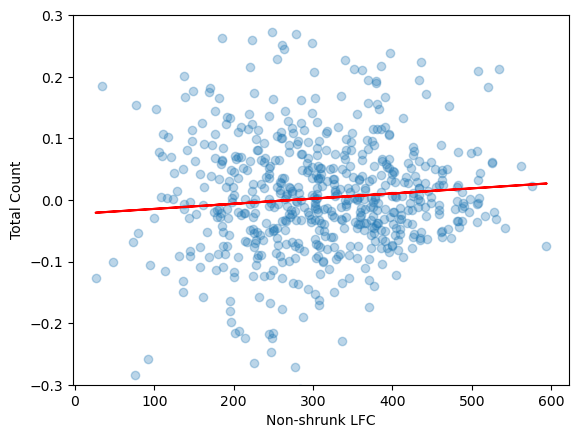

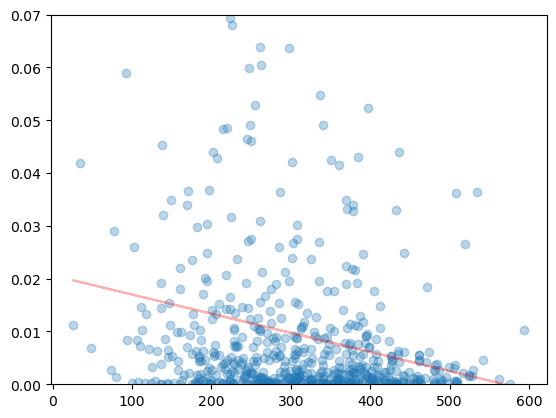

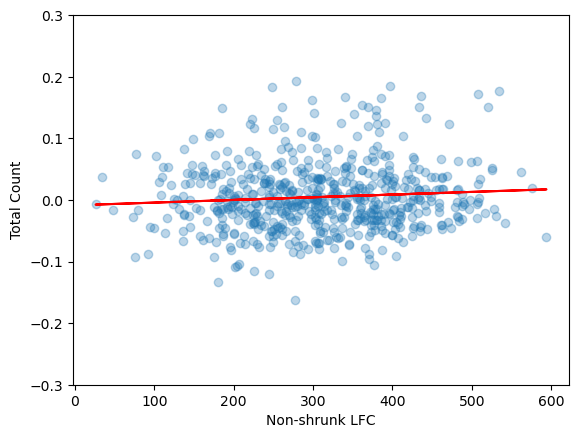

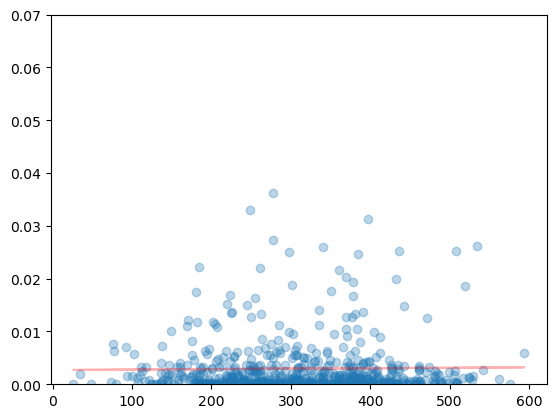

In [109]:
plt.scatter(total_deduplicated_counts_per_guide, mean_lfc_nonshrunk_list, alpha=0.3)
plt.plot(total_deduplicated_counts_per_guide, mean_lfc_nonshrunk_list_Y_hat, color="red")
plt.ylabel("Total Count")
plt.xlabel("Non-shrunk LFC")
plt.ylim(-0.3, 0.3)
plt.show()

plt.scatter(total_deduplicated_counts_per_guide, mean_lfc_nonshrunk_list_M_squared_residuals, alpha=0.3)
plt.plot(total_deduplicated_counts_per_guide, mean_lfc_nonshrunk_list_M_squared_residuals_Y_hat, alpha=0.3, color="red")
plt.ylim(0,0.07)
plt.show()

plt.scatter(total_deduplicated_counts_per_guide, mean_lfc_shrunk_list, alpha=0.3)
plt.plot(total_deduplicated_counts_per_guide, mean_lfc_shrunk_list_Y_hat, color="red")
plt.ylabel("Total Count")
plt.xlabel("Non-shrunk LFC")
plt.ylim(-0.3, 0.3)
plt.show()

plt.scatter(total_deduplicated_counts_per_guide, mean_lfc_shrunk_list_M_squared_residuals, alpha=0.3)
plt.plot(total_deduplicated_counts_per_guide, mean_lfc_shrunk_list_M_squared_residuals_Y_hat, alpha=0.3, color="red")
plt.ylim(0,0.07)
plt.show()


In [106]:
print(mean_lfc_nonshrunk_list_M_BP_statistic)
print(mean_lfc_shrunk_list_M_BP_statistic)

25.17205562053675
0.18684112504796513


In [110]:
from scipy.stats import chi

print(1- chi.cdf(mean_lfc_nonshrunk_list_M_BP_statistic, 1))
print(1- chi.cdf(mean_lfc_shrunk_list_M_BP_statistic, 1))

0.0
0.8517852015275111


In [6]:
# test, can delete
import numpy as np
np.mean(np.asarray([[2,3,4,5,6,7],[1,2,3,4,5,6],[3,4,5,6,7,8]]), axis=0)

array([2., 3., 4., 5., 6., 7.])

11.0

Next get statistic for heteroscedasticity. Most tests use residuals, so just fit a null regression model (i.e. y=0.5 or y=0) to get residuals, then run the typical tests such as Bruesch PAgan test.

Test optimization of minimizing heteroscedasticity

In [114]:
def optimize_shrinkage_prior(alpha_prior, beta_prior, monte_carlo_trials=1000):
    mean_lfc_shrunk_list = []
    mean_prop_shrunk_list = []

    mean_lfc_nonshrunk_list = []
    mean_prop_nonshrunk_list = []
    for guide_i in range(num_target_null_guides+num_target_positive_guides+num_ctrl_guides):
        pop1_guide_counts_list = [pop1_guide_counts_list_all[rep_i][guide_i] for rep_i in range(reps)]
        pop2_guide_counts_list = [pop2_guide_counts_list_all[rep_i][guide_i] for rep_i in range(reps)]
        mean_lfc_shrunk, mean_prop_shrunk, mean_lfc_nonshrunk, mean_prop_nonshrunk = shrink_LFC_from_counts(pop1_guide_counts_list, pop2_guide_counts_list, pop1_dup_factor_list, pop2_dup_factor_list, pop1_ctrl_counts_list, pop2_ctrl_counts_list, alpha_prior=alpha_prior, beta_prior=beta_prior, baseline_proportion=0.5, monte_carlo_trials=monte_carlo_trials)
        mean_lfc_shrunk_list.append(mean_lfc_shrunk)
        mean_prop_shrunk_list.append(mean_prop_shrunk)
        mean_lfc_nonshrunk_list.append(mean_lfc_nonshrunk)
        mean_prop_nonshrunk_list.append(mean_prop_nonshrunk)
    
    beta_intercept_ols_nonshrunk, beta_coefficient_ols_nonshrunk = get_ols_estimators(total_deduplicated_counts_per_guide, mean_lfc_nonshrunk_list)
    beta_intercept_ols_shrunk, beta_coefficient_ols_shrunk = get_ols_estimators(total_deduplicated_counts_per_guide, mean_lfc_shrunk_list)

    mean_lfc_nonshrunk_list_Y_hat = calculate_Y_hat(total_deduplicated_counts_per_guide, beta_intercept_ols_nonshrunk, beta_coefficient_ols_nonshrunk)
    mean_lfc_shrunk_list_Y_hat = calculate_Y_hat(total_deduplicated_counts_per_guide, beta_intercept_ols_shrunk, beta_coefficient_ols_shrunk)

    mean_lfc_nonshrunk_list_M_squared_residuals = calculate_squared_residuals(mean_lfc_nonshrunk_list, mean_lfc_nonshrunk_list_Y_hat)
    mean_lfc_shrunk_list_M_squared_residuals = calculate_squared_residuals(mean_lfc_shrunk_list, mean_lfc_shrunk_list_Y_hat)

    beta_intercept_ols_nonshrunk_squared_residuals, beta_coefficient_ols_nonshrunk_squared_residuals = get_ols_estimators(total_deduplicated_counts_per_guide, mean_lfc_nonshrunk_list_M_squared_residuals)
    beta_intercept_ols_shrunk_squared_residuals, beta_coefficient_ols_shrunk_squared_residuals = get_ols_estimators(total_deduplicated_counts_per_guide, mean_lfc_shrunk_list_M_squared_residuals)

    mean_lfc_nonshrunk_list_M_squared_residuals_Y_hat = calculate_Y_hat(total_deduplicated_counts_per_guide, beta_intercept_ols_nonshrunk_squared_residuals, beta_coefficient_ols_nonshrunk_squared_residuals)
    mean_lfc_shrunk_list_M_squared_residuals_Y_hat = calculate_Y_hat(total_deduplicated_counts_per_guide, beta_intercept_ols_shrunk_squared_residuals, beta_coefficient_ols_shrunk_squared_residuals)

    mean_lfc_nonshrunk_list_M_squared_residuals_r_squared = calculate_r_squared(mean_lfc_nonshrunk_list_M_squared_residuals, mean_lfc_nonshrunk_list_M_squared_residuals_Y_hat)
    mean_lfc_shrunk_list_M_squared_residuals_r_squared = calculate_r_squared(mean_lfc_shrunk_list_M_squared_residuals, mean_lfc_shrunk_list_M_squared_residuals_Y_hat)

    mean_lfc_nonshrunk_list_M_BP_statistic = len(total_deduplicated_counts_per_guide) * mean_lfc_nonshrunk_list_M_squared_residuals_r_squared
    mean_lfc_shrunk_list_M_BP_statistic = len(total_deduplicated_counts_per_guide) * mean_lfc_shrunk_list_M_squared_residuals_r_squared

    return (mean_lfc_nonshrunk_list_M_BP_statistic, mean_lfc_shrunk_list_M_BP_statistic), (total_deduplicated_counts_per_guide, mean_lfc_nonshrunk_list, mean_lfc_nonshrunk_list_Y_hat, mean_lfc_nonshrunk_list_M_squared_residuals, mean_lfc_nonshrunk_list_M_squared_residuals_Y_hat, mean_lfc_shrunk_list, mean_lfc_shrunk_list_Y_hat, mean_lfc_shrunk_list_M_squared_residuals, mean_lfc_shrunk_list_M_squared_residuals_Y_hat)

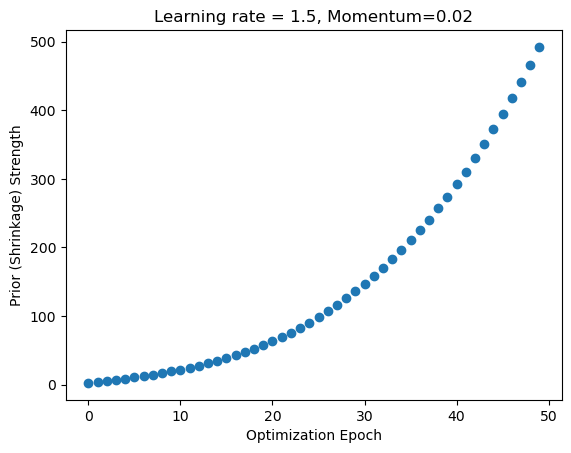

In [112]:
original_learning_rate = 1.5
learning_rate = original_learning_rate
momentum = 0.02
epochs = 50

tested_priors_list = []
current_prior = 1
for epoch_i in range(epochs):
    learning_rate = learning_rate + (epoch_i*momentum)
    current_prior = current_prior + learning_rate
    tested_priors_list.append(current_prior)
plt.scatter(list(range(epochs)), tested_priors_list)
plt.xlabel("Optimization Epoch")
plt.ylabel("Prior (Shrinkage) Strength")
plt.title("Learning rate = {}, Momentum={}".format(original_learning_rate, momentum))
plt.show()

In [115]:
original_learning_rate = 1.5
learning_rate = original_learning_rate
momentum = 0.02
epochs = 50

mean_lfc_nonshrunk_list_M_BP_statistic_epoch_list = []
mean_lfc_shrunk_list_M_BP_statistic_epoch_list = []

total_deduplicated_counts_per_guide_epoch_list = []
mean_lfc_nonshrunk_list_epoch_list = []
mean_lfc_nonshrunk_list_Y_hat_epoch_list = []
mean_lfc_nonshrunk_list_M_squared_residuals_epoch_list = []
mean_lfc_nonshrunk_list_M_squared_residuals_Y_hat_epoch_list = []

mean_lfc_shrunk_list_epoch_list = []
mean_lfc_shrunk_list_Y_hat_epoch_list = []
mean_lfc_shrunk_list_M_squared_residuals_epoch_list = []
mean_lfc_shrunk_list_M_squared_residuals_Y_hat_epoch_list = []


tested_priors_list = []
current_prior = 1
for epoch_i in range(epochs):
    print("Epoch: {}".format(epoch_i))
    learning_rate = learning_rate + (epoch_i*momentum)
    current_prior = current_prior + learning_rate
    tested_priors_list.append(current_prior)

    (mean_lfc_nonshrunk_list_M_BP_statistic, mean_lfc_shrunk_list_M_BP_statistic), (total_deduplicated_counts_per_guide, mean_lfc_nonshrunk_list, mean_lfc_nonshrunk_list_Y_hat, mean_lfc_nonshrunk_list_M_squared_residuals, mean_lfc_nonshrunk_list_M_squared_residuals_Y_hat, mean_lfc_shrunk_list, mean_lfc_shrunk_list_Y_hat, mean_lfc_shrunk_list_M_squared_residuals, mean_lfc_shrunk_list_M_squared_residuals_Y_hat) = optimize_shrinkage_prior(current_prior, current_prior, monte_carlo_trials=250)

    mean_lfc_nonshrunk_list_M_BP_statistic_epoch_list.append(mean_lfc_nonshrunk_list_M_BP_statistic)
    mean_lfc_shrunk_list_M_BP_statistic_epoch_list.append(mean_lfc_shrunk_list_M_BP_statistic)

    total_deduplicated_counts_per_guide_epoch_list.append(total_deduplicated_counts_per_guide)
    mean_lfc_nonshrunk_list_epoch_list.append(mean_lfc_nonshrunk_list)
    mean_lfc_nonshrunk_list_Y_hat_epoch_list.append(mean_lfc_nonshrunk_list_Y_hat)
    mean_lfc_nonshrunk_list_M_squared_residuals_epoch_list.append(mean_lfc_nonshrunk_list_M_squared_residuals)
    mean_lfc_nonshrunk_list_M_squared_residuals_Y_hat_epoch_list.append(mean_lfc_nonshrunk_list_M_squared_residuals_Y_hat)
    
    mean_lfc_shrunk_list_epoch_list.append(mean_lfc_shrunk_list)
    mean_lfc_shrunk_list_Y_hat_epoch_list.append(mean_lfc_shrunk_list_Y_hat)
    mean_lfc_shrunk_list_M_squared_residuals_epoch_list.append(mean_lfc_shrunk_list_M_squared_residuals)
    mean_lfc_shrunk_list_M_squared_residuals_Y_hat_epoch_list.append(mean_lfc_shrunk_list_M_squared_residuals_Y_hat)
    

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49


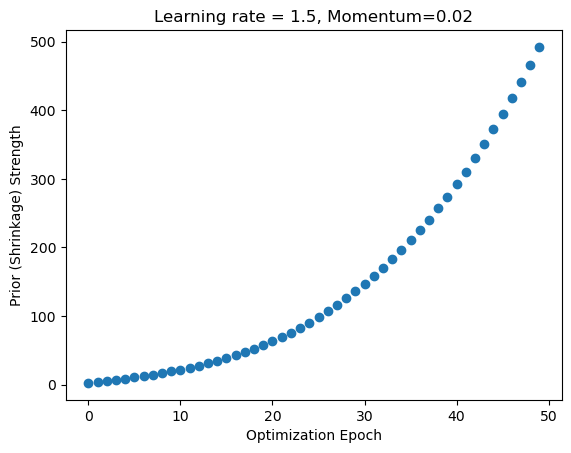

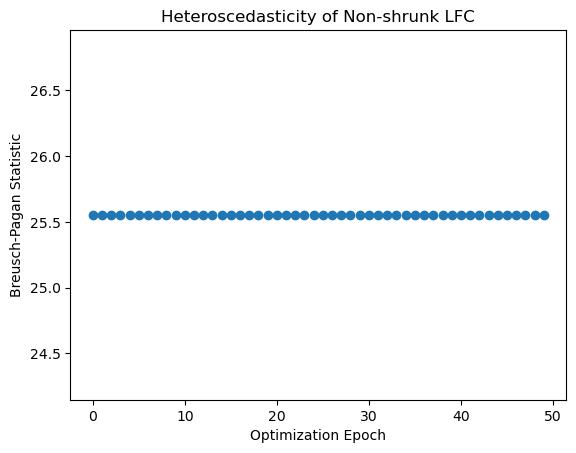

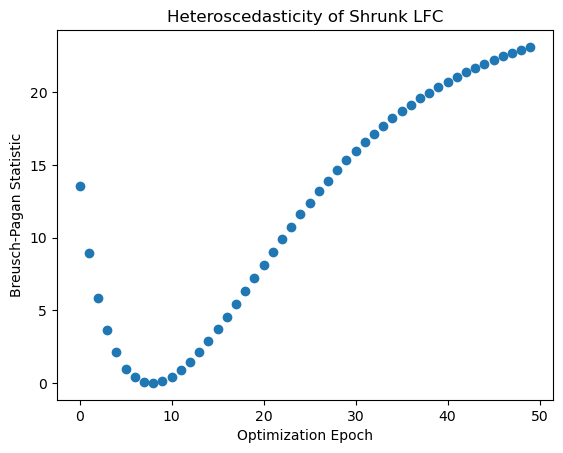

In [116]:
plt.scatter(list(range(epochs)), tested_priors_list)
plt.xlabel("Optimization Epoch")
plt.ylabel("Prior (Shrinkage) Strength")
plt.title("Learning rate = {}, Momentum={}".format(original_learning_rate, momentum))
plt.show()

plt.scatter(list(range(epochs)), mean_lfc_nonshrunk_list_M_BP_statistic_epoch_list)
plt.xlabel("Optimization Epoch")
plt.ylabel("Breusch-Pagan Statistic")
plt.title("Heteroscedasticity of Non-shrunk LFC".format(original_learning_rate, momentum))
plt.show()

plt.scatter(list(range(epochs)), mean_lfc_shrunk_list_M_BP_statistic_epoch_list)
plt.xlabel("Optimization Epoch")
plt.ylabel("Breusch-Pagan Statistic")
plt.title("Heteroscedasticity of Shrunk LFC".format(original_learning_rate, momentum))
plt.show()

In [117]:
min_index = np.argmin(mean_lfc_shrunk_list_M_BP_statistic_epoch_list)
print("Chosen Prior: {}".format(tested_priors_list[min_index]))

Chosen Prior: 16.900000000000002


In [127]:
def plot_shrinkage_results(total_deduplicated_counts_per_guide, mean_lfc_nonshrunk_list, mean_lfc_nonshrunk_list_Y_hat, mean_lfc_nonshrunk_list_M_squared_residuals, mean_lfc_nonshrunk_list_M_squared_residuals_Y_hat, mean_lfc_shrunk_list, mean_lfc_shrunk_list_Y_hat, mean_lfc_shrunk_list_M_squared_residuals, mean_lfc_shrunk_list_M_squared_residuals_Y_hat):
    plt.scatter(total_deduplicated_counts_per_guide, mean_lfc_nonshrunk_list, alpha=0.3)
    plt.plot(total_deduplicated_counts_per_guide, mean_lfc_nonshrunk_list_Y_hat, color="red")
    plt.xlabel("Total Count")
    plt.ylabel("Non-shrunk LFC")
    plt.ylim(-0.3, 0.3)
    plt.title("Scatter of raw LFC")
    plt.show()

    plt.scatter(total_deduplicated_counts_per_guide, mean_lfc_nonshrunk_list_M_squared_residuals, alpha=0.3)
    plt.plot(total_deduplicated_counts_per_guide, mean_lfc_nonshrunk_list_M_squared_residuals_Y_hat, alpha=0.3, color="red")
    plt.ylim(0,0.07)
    plt.title("Scatter of raw LFC regression residuals")
    plt.show()

    plt.scatter(total_deduplicated_counts_per_guide, mean_lfc_shrunk_list, alpha=0.3)
    plt.plot(total_deduplicated_counts_per_guide, mean_lfc_shrunk_list_Y_hat, color="red")
    plt.xlabel("Total Count")
    plt.ylabel("Shrunk LFC")
    plt.ylim(-0.3, 0.3)
    plt.title("Scatter of shrunk LFC")
    plt.show()

    plt.scatter(total_deduplicated_counts_per_guide, mean_lfc_shrunk_list_M_squared_residuals, alpha=0.3)
    plt.plot(total_deduplicated_counts_per_guide, mean_lfc_shrunk_list_M_squared_residuals_Y_hat, alpha=0.3, color="red")
    plt.ylim(0,0.07)
    plt.title("Scatter of shrunk LFC regression residuals")
    plt.show()

Optimal Prior

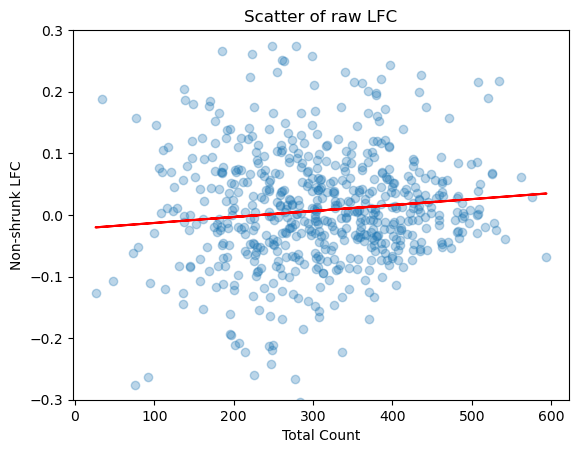

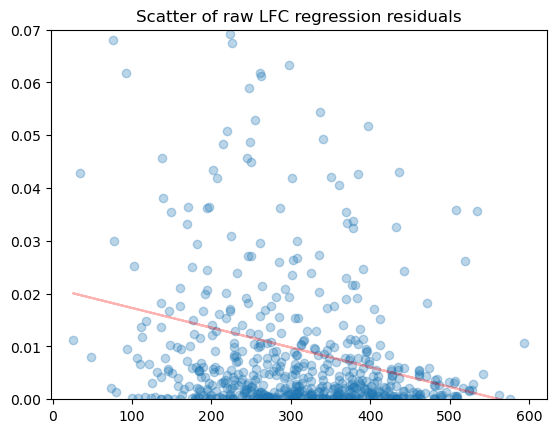

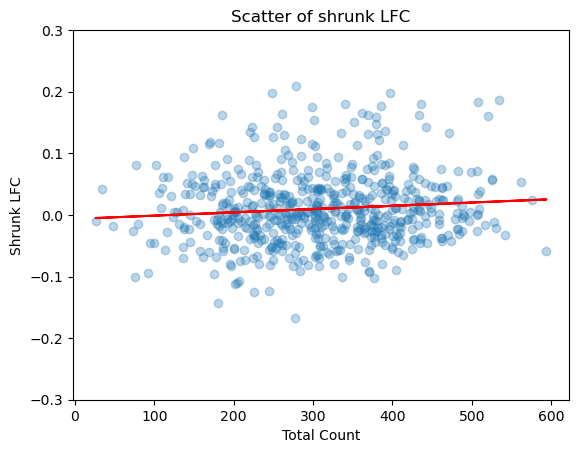

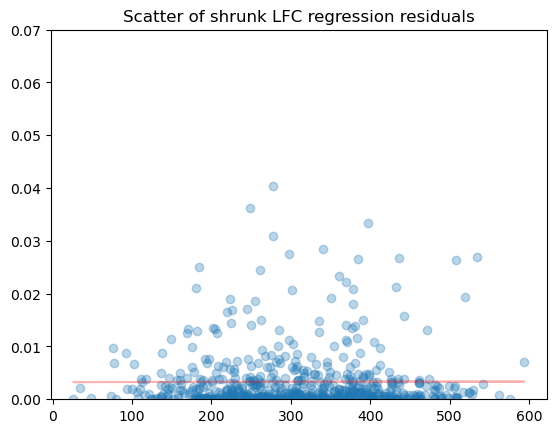

In [128]:
index = min_index
plot_shrinkage_results(total_deduplicated_counts_per_guide_epoch_list[index], mean_lfc_nonshrunk_list_epoch_list[index], mean_lfc_nonshrunk_list_Y_hat_epoch_list[index], mean_lfc_nonshrunk_list_M_squared_residuals_epoch_list[index], mean_lfc_nonshrunk_list_M_squared_residuals_Y_hat_epoch_list[index], mean_lfc_shrunk_list_epoch_list[index], mean_lfc_shrunk_list_Y_hat_epoch_list[index], mean_lfc_shrunk_list_M_squared_residuals_epoch_list[index], mean_lfc_shrunk_list_M_squared_residuals_Y_hat_epoch_list[index])

Over-shrunk Prior

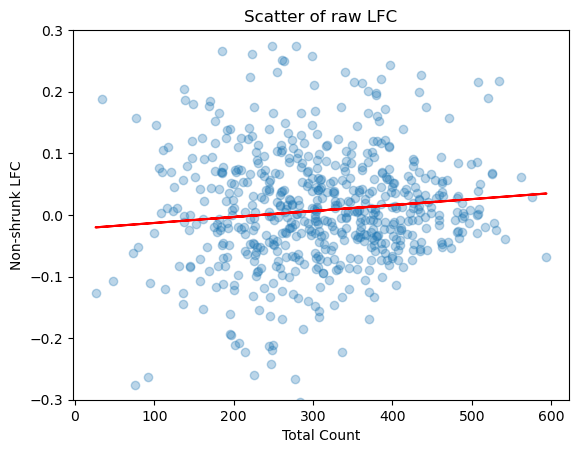

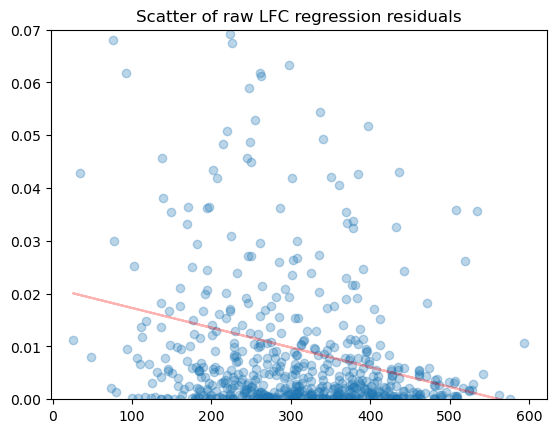

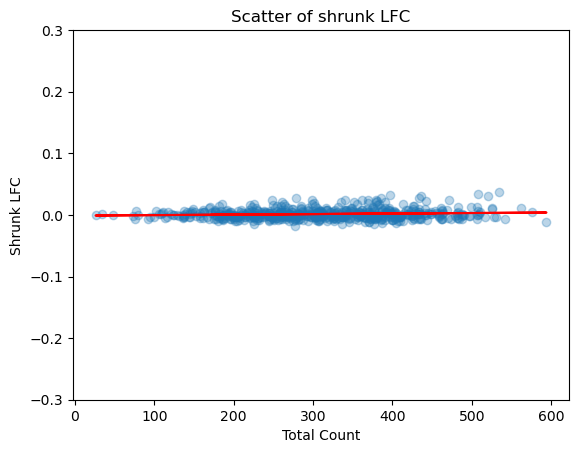

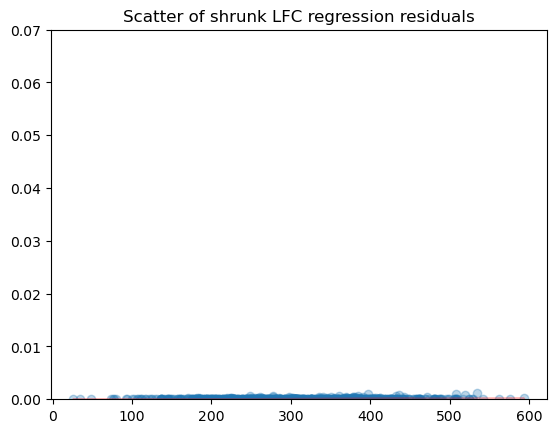

In [129]:
index = 49
plot_shrinkage_results(total_deduplicated_counts_per_guide_epoch_list[index], mean_lfc_nonshrunk_list_epoch_list[index], mean_lfc_nonshrunk_list_Y_hat_epoch_list[index], mean_lfc_nonshrunk_list_M_squared_residuals_epoch_list[index], mean_lfc_nonshrunk_list_M_squared_residuals_Y_hat_epoch_list[index], mean_lfc_shrunk_list_epoch_list[index], mean_lfc_shrunk_list_Y_hat_epoch_list[index], mean_lfc_shrunk_list_M_squared_residuals_epoch_list[index], mean_lfc_shrunk_list_M_squared_residuals_Y_hat_epoch_list[index])

Under-shrunk Prior

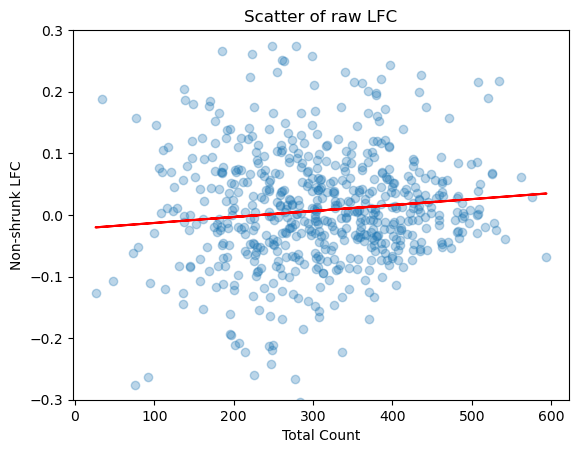

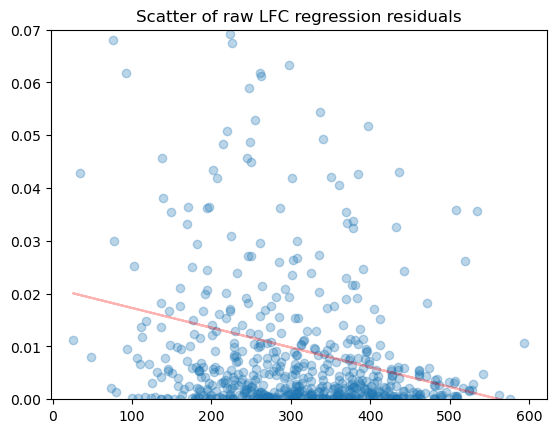

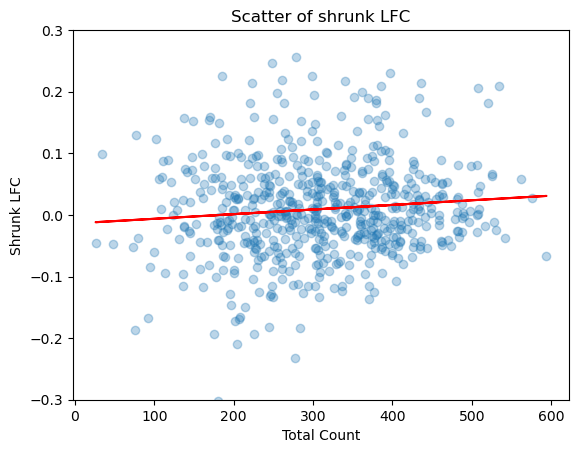

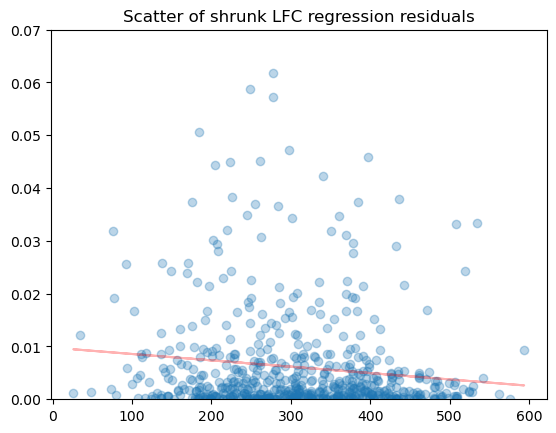

In [130]:
index = 1
plot_shrinkage_results(total_deduplicated_counts_per_guide_epoch_list[index], mean_lfc_nonshrunk_list_epoch_list[index], mean_lfc_nonshrunk_list_Y_hat_epoch_list[index], mean_lfc_nonshrunk_list_M_squared_residuals_epoch_list[index], mean_lfc_nonshrunk_list_M_squared_residuals_Y_hat_epoch_list[index], mean_lfc_shrunk_list_epoch_list[index], mean_lfc_shrunk_list_Y_hat_epoch_list[index], mean_lfc_shrunk_list_M_squared_residuals_epoch_list[index], mean_lfc_shrunk_list_M_squared_residuals_Y_hat_epoch_list[index])

In [147]:
range

0

Attempt setting the prior based on spatial information via the Gaussian kernel

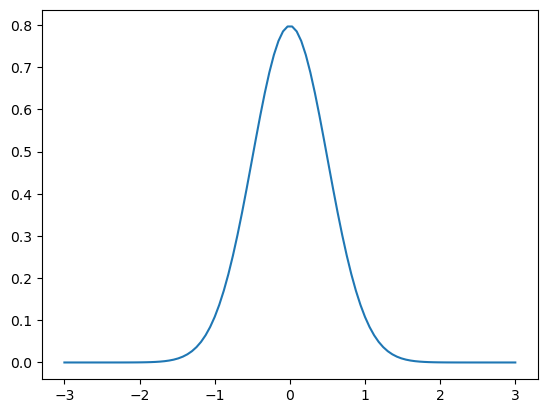

In [156]:
point1 = 0
range = np.linspace(-3, 3, 100)
b=0.5

kernel = np.exp(-(range-point1)**2/(2*b**2))/(b*np.sqrt(2*np.pi))

plt.plot(range, kernel)

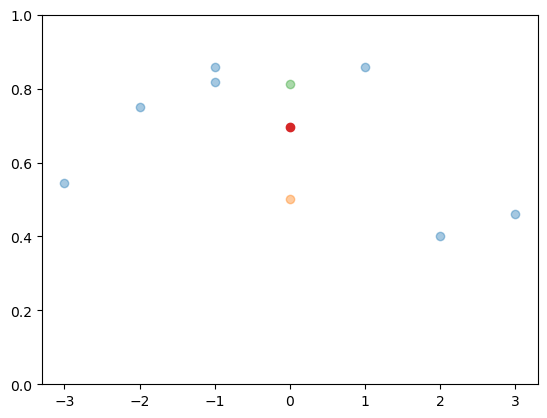

In [207]:

guide_1 = (6, 2, -2)
guide_2 = (6, 1, -1)
guide_3 = (9, 2, -1)

guide_4 = (2, 3, 2)
guide_5 = (6, 1, 1)
guide_6 = (6, 5, -3)
guide_7 = (6, 7, 3)

neighboring_guides = [guide_1, guide_2, guide_3, guide_4, guide_5, guide_6, guide_7]

guide_0 = (2,2,0)

plt.scatter([g[2] for g in neighboring_guides], [g[0]/(g[0]+g[1]) for g in neighboring_guides], alpha=0.4) 
plt.scatter(guide_0[2], guide_0[0]/(guide_0[0]+guide_0[1]), alpha=0.4)


gaussian_kernel = lambda range, point, bandwidth : np.exp(-(range-point)**2/(2*bandwidth**2))/(bandwidth*np.sqrt(2*np.pi))

bandwidth = 1
prior_strength = 1
prior_alpha = prior_strength * np.sum([gaussian_kernel(g[2], guide_0[2], bandwidth)*g[0] for g in neighboring_guides])
prior_beta = prior_strength * np.sum([gaussian_kernel(g[2], guide_0[2], bandwidth)*g[1] for g in neighboring_guides])
plt.scatter(guide_0[2], prior_alpha/(prior_alpha+prior_beta), alpha=0.4)
plt.scatter(guide_0[2], (prior_alpha+guide_0[0])/(prior_alpha+guide_0[0] + prior_beta+guide_0[1]))
plt.ylim(0, 1)
plt.show()


In [216]:
np.asarray([3,6,9]) / np.asarray([3,2])

ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [214]:
placeholder

array([1., 0., 0.])

In [213]:
placeholder[0] = placeholder[0] + 1

Kullback-Leibler Divergence 

In [240]:
scipy.special.beta(alpha_g, beta_g)

0.16666666666666666

In [10]:
import scipy.special
import numpy as np
alpha_f = 1
beta_f = 1
alpha_g = 2
beta_g = 2


def KL_beta(alpha_f, beta_f, alpha_g, beta_g):
    return np.log(scipy.special.beta(alpha_g, beta_g)/(scipy.special.beta(alpha_f, beta_f))) + ((alpha_f - alpha_g)*(scipy.special.digamma(alpha_f) - scipy.special.digamma(alpha_f+beta_f))) + ((beta_f - beta_g)*(scipy.special.digamma(beta_f) - scipy.special.digamma(alpha_f+beta_f)))


In [11]:
KL_beta(alpha_f=3, beta_f=3, alpha_g=3, beta_g=3)

0.0

In [17]:
print(KL_beta(alpha_f=3, beta_f=2.5, alpha_g=6, beta_g=6))
print(KL_beta(alpha_f=12, beta_f=6, alpha_g=6, beta_g=5))

0.295363774503687
0.40213660564753306
